(chap:8-simple)=
# 単回帰分析

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import wooldridge  # wooldridgeのデータ・パッケージ
from statsmodels.formula.api import ols  # 回帰分析のパッケージ
from see import see  # 属性を調べるパッケージ
from numba import njit  # シミュレーションの計算を高速化する

## 説明

```{margin}
<div name="html-admonition">
Do you want to read in a differnt language? Open the 
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translated version" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/>
in English or the language of your choice.
</div>
```

説明変数が１つの単回帰（Simple Regression）を考える。

$$y_i=\beta_0+\beta_1 x_i + u_i$$

ここで使う変数の呼び名は複数あるので混同しないように。
* $y_i$： 被説明変数（explained variable）
    * 従属変数（dependent variable）
    * regressand
* $x_i$： 説明変数（explanatory variable）
    * 独立変数（independent variable）
    * regressor
* $u_i$： 誤差項（errors)
    * 観測不可能なランダムな要素
    * 平均はゼロと仮定する（重回帰分析の章でより詳しく説明する）
* $i=1,2,...n$：観測値のインデックス
* $\beta_0$：定数項（観測不可能なため推定する）
* $\beta_1$：スロープ係数（観測不可能なため推定する）

---
**最小二乗法推定法（Ordinary Least Squares; OLS）**

$$\sum_{i=1}^n\left(y_i-\beta_0-\beta_1 x_i\right)^2$$

を最小化する$\beta_0$と$\beta_1$を選択すると以下を得る：

$$
\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x},\qquad\qquad
\hat{\beta}_1=\frac{\text{Cov}(x,y)}{\text{Var}(x)}
$$

* `^`（ハット）がある変数（$\hat{\beta}_0$と$\hat{\beta}_1$）を**OLS推定量**と呼ぶ
* `-`（バー）がある変数（例えば，$\bar{y}$）は平均値
* $\text{Cov}(x,y)=$ $x$と$y$の共分散
* $\text{Var}(x)=$ $x$の分散
* $x$のように添え字$i$を省いた場合は，$x_1$から$x_n$までの全ての観測値という意味（$y$も同じ）

また以下を定義する。
* 予測値 $\hat{y}_i$

$$\hat{y}_i=\hat{\beta}_0 + \hat{\beta}_1x_i$$

* 残差 $\hat{u}_i$

$$\hat{u}_i=y_i-\hat{y}_i$$

## データ

Wooldridge (2019)で使われるデータセットは全て`wooldridge`のパッケージに含まれている。そのパッケージからからデータを読み込んで使うことにする。

````{note}
MacではTerminal、WindowsではGit Bashを使い、次のコマンドで`wooldridge`パッケージをインストールできる。
```
pip install wooldridge
```
````

使う関数は`data()`であり，引数なしで実行するとデータセットのリストが表示される。

In [2]:
wooldridge.data()

  J.M. Wooldridge (2016) Introductory Econometrics: A Modern Approach,
  Cengage Learning, 6th edition.

  401k       401ksubs    admnrev       affairs     airfare
  alcohol    apple       approval      athlet1     athlet2
  attend     audit       barium        beauty      benefits
  beveridge  big9salary  bwght         bwght2      campus
  card       catholic    cement        census2000  ceosal1
  ceosal2    charity     consump       corn        countymurders
  cps78_85   cps91       crime1        crime2      crime3
  crime4     discrim     driving       earns       econmath
  elem94_95  engin       expendshares  ezanders    ezunem
  fair       fertil1     fertil2       fertil3     fish
  fringe     gpa1        gpa2          gpa3        happiness
  hprice1    hprice2     hprice3       hseinv      htv
  infmrt     injury      intdef        intqrt      inven
  jtrain     jtrain2     jtrain3       kielmc      lawsch85
  loanapp    lowbrth     mathpnl       meap00_01   meap01
  meap93    

この中にある`wage1`を使う。データ・セットを読み込むには、引数にデータ・セット名を文字列として入力する。返り値は`DataFrame`であり、
回帰分析に使うために`df`に割り当てる。

In [3]:
df = wooldridge.data('wage1')

オプション`description=True`を追加するとデータの説明を表示することができる。

In [4]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

このデータを使い次の問題を考える。

> 教育水準は賃金にどのような影響を与えるのか

* 被説明変数：`wage`（平均時給、単位：米ドル）
* 説明変数：`educ`（教育年数、単位：年）

まず関係する変数だけを取り出してみる。

In [5]:
df = df.loc[:,['wage','educ']]

最初の3行の表示をしてみよう。


In [6]:
df.head(3)

,wage,educ
0,3.10,11
1,3.24,12
2,3.00,11


次に`DataFrame`の特徴を確認する。

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    526 non-null    float64
 1   educ    526 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 8.3 KB


また記述統計も必ず確認するように。

In [8]:
df.describe()

,wage,educ
count,526.000000,526.000000
mean,5.896103,12.562738
std,3.693086,2.769022
min,0.530000,0.000000
25%,3.330000,12.000000
50%,4.650000,12.000000
75%,6.880000,14.000000
max,24.980000,18.000000


`.head()`，`.tail()`，`.info()`そして`.describe()`を使い`df`の情報を確認し，データのイメージ作りをすることは回帰分析に役立つだろう。

## 「手計算」

`Python`では回帰分析の計算を自動化するパッケージが提供されており、後ほどその１つを紹介する。その前に、自動計算にはどのようなコードが使われているかを感じてもらうために「手計算」で、即ち、上で示した$\hat{\beta}_0$と$\hat{\beta}_1$の式を使い係数の推定値を計算してみる。まず分散共分散行列を計算する。

In [9]:
mat_wage_educ = np.cov(df['wage'],df['educ'])
mat_wage_educ

array([[13.63888436,  4.150864  ],
       [ 4.150864  ,  7.66748506]])

共分散の値を`cov_wage_edu`に割り当てる。

In [10]:
cov_wage_educ = mat_wage_educ[0, 1]
cov_wage_educ

4.150863998572982

`wage`と`educ`の分散は次のコードで取得できる。

In [11]:
mat_wage_educ[0,0], mat_wage_educ[1,1]

(13.638884363775004, 7.667485062466049)

次のように計算しても同じ値となる。

In [12]:
var_wage = df['wage'].var(ddof=1)
var_educ = df['educ'].var(ddof=1)
var_wage, var_educ

(13.638884363775007, 7.667485062466051)

それぞれの変数の平均を計算する。

In [13]:
mean_wage = df['wage'].mean()
mean_educ = df['educ'].mean()

上の式に従って$\beta_1$の推定値 $\left(\hat{\beta}_1\right)$を計算する。

In [14]:
b1hat = cov_wage_educ / var_educ
b1hat

0.5413592546651746

**＜結果の解釈＞**

`b1hat`は次式の推定結果である。

$$y = \beta_0+\beta_1x+u$$

この式を$x$について微分すると

$$
\dfrac{dy}{dx}=\dfrac{y\text{の変化}}{x\text{の増加}}
=
\left(
\begin{array}{l}
    x\text{が1単位増加した}\\
    \text{場合の}yの\text{変化}
    \phantom{春}
\end{array}
\right)
=\beta_1
$$

となる。即ち，$\beta_1$は教育年数が１年増加した場合，平均時給は何ドル変化するかを示している。OLS推定結果は教育年数が１年増えると賃金は約0.54ドル上昇することを示している。

同様に$\beta_0$の推定値 $\left(\hat{\beta}_0\right)$も計算する。

In [15]:
b0hat = mean_wage - b1hat * mean_educ
b0hat

-0.9048516119572119

## `statsmodels`を使う

(sec:8-statsmodels)=
## `statsmodels`を使う

`Python`では簡単なコードで回帰分析に関する多くの計算を行うことができるパッケージが提供されている。その内、代表的なパッケージが`statsmodels`である。次の順番で使い方を説明する。
* `ols`サブパッケージを読み込む
* 回帰式を定義する
* 推定値の自動計算

**Step 1: サブパッケージの読み込み**

`statsmodels`には多くのサブパッケージや関数があるが，ここでは回帰式を文字列で書くことができる`ols`関数をつかう。（他のコードの書き方もあるが，他のトピックで扱う。）`ols`はこのページの冒頭で次のコードでインポートされている。
```
from statsmodels.formula.api import ols
```

**Step 2: 回帰式の定義**

* 式を`''`で囲む（文字列）
* 定数項である（$\beta_0$）は自動的に挿入される。
    * 定数を省きたい場合は式に`-1`を加える。
    * 後に扱う`linearmodels`パッケージでは，定数が自動的に挿入されないので要注意。

---
定数項がある場合：
```
被説明変数 ~ 説明変数
```
定数項がない場合：
```
被説明変数 ~ -1 + 説明変数
```

---
`wage`を被説明変数にし，定数項を加えて`educ`を説明変数をする場合，次のように書くことになる。

In [16]:
formula = 'wage ~ educ'

**Step 3: 自動計算**

まず自動計算の準備として計算の対象となるもの（インスタンスと呼ばれるオブジェクト）を生成し、ここでは"model"の省略形の変数`mod`に割り当てる（`mod`でなくとも好きな変数名でOK）。ここで第１引数は上で定義した回帰式，第２引数`data`は使用するデータをを指定する。

In [17]:
mod = ols(formula, data=df)

`mod`の属性を調べてみよう。

In [18]:
see(mod)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .data
    .df_model          .df_resid          .endog             .endog_names
    .exog              .exog_names        .fit()
    .fit_regularized()                    .formula           .from_formula()
    .get_distribution()                   .hessian()         .hessian_factor()
    .information()     .initialize()      .k_constant        .loglike()
    .nobs              .predict()         .rank              .score()
    .weights           .wendog            .wexog             .whiten()

この中にOLS関連の計算を一瞬で実行するメソッド`fit()`が準備されており、それを使い結果を`res`に割り当てる（`res`はresultの略）。

In [19]:
res = mod.fit()

上の２つを分けずに一行で書いても良い。
```
res = ols(formula, data=df).fit()
```
`res`の属性を確認してみよう。

In [20]:
see(res)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .eigenvals           .el_test()
    .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .info_criteria()     .initialize()        .k_constant          .llf
    .load()              .model               .mse_mod

例えば，上のリストの中に`.params`とあるが，この属性を使い係数の推定値を取り出すことができる。

In [21]:
res.params

Intercept   -0.904852
educ         0.541359
dtype: float64

「手計算」での計算結果と同じだと確認できる。

また`wage`の予測値は`res.fittedvalues`もしくは`res.predict()`で得ることができる。`res.fittedvalues`は属性であり`res.predict()`はメソッドであるが、後者は引数がない場合は前者と同じ結果を返すことになる。

上のリストが示すように`res`には多くの情報が詰まっており，これらを駆使して図を描いたり推定値の検定をおこなうことになる。

この中にあるメソッド`summary()`を使うと，主な結果がまとめられた表を出力することができる。

In [22]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     103.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           2.78e-22
Time:                        22:28:13   Log-Likelihood:                -1385.7
No. Observations:                 526   AIC:                             2775.
Df Residuals:                     524   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.1

ここで`print()`関数を使ったが、使わなくとも同じ内容を表示できるので試してみよう。

また，この表は３つの表から構成されており，必要な部分だけを表示することも可能である。
```
res.summary().tables[0]
res.summary().tables[1]
res.summary().tables[2]
```
例えば，係数の推定値に関する基本的な統計量だけを表示するには以下のようにすれば良い。

In [23]:
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.187      -2.250       0.441
educ           0.5414      0.053     10.167      0.000       0.437       0.646


````{note}
`statsmodels 13.0`では`.summary()`に引数`slim`（デフォルトは`False`）が追加されており，`.tables`を使わずに次のコードで簡略化された表を表示できる。
```
result.summary(slim=True)
```
````

**＜表の説明＞**

表は3つのセクションから構成されている。
* 上段にはOLS推定の基本的な情報が表示されている。
    * 左側
        * `Dep. Variable`：被説明変数
        * `Model`：モデル
        * `Method`：手法
        * `Data`：日にち
        * `Time`：時間
        * `No. Observation`：標本の大きさ
        * `Df Residuals`：残差の自由度
        * `Df Model`：モデルの自由度（定数項以外の説明変数の数）
        * `Covariance Type`：共分散のタイプ
    * 右側
        * `R-squared`：決定係数
        * `adj. R-squared`：自由度調整済み決定係数
        * `F-statistic`：$F$統計量
        * `Prob (F-statistic)`：$F$値
        * `Log-Likelihood`：対数尤度
        * `AIC`：赤池情報量規準
        * `BIC`：ベイズ情報量規準
* 中段には主な推定結果が表示される。
    * 列ラベル
        * `coef`：係数
        * `std err`：標準誤差
        * `t`：$t$値
        * `P>|t|`：$p$値
        * `[0.025,0.975]`：信頼区間（5%)
    * 行ラベル
        * `Intercept`：定数項
        * `tfp_relative`：説明変数（選択する変数によって変わる）
* 下段には様々な検定などに関する数値が並んでいる。
    * 左側
        * `Omnibus`：オムニバス検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(Omnibus)`：オムニバス検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Skew`：残差の歪度（正規分布であれば`0`）
        * `Kurtosis`：残差の尖度（正規分布であれば`3`）
    * 右側
        * `Durbin-Watson`：ダービン・ワトソン統計量（残差の自己相関の検定）
        * `Jarque-Bera (JB)`：ジャーク・ベラ検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(JB)`：ジャーク・ベラ検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Cond. No.`：条件指数（Condition Index）の最大値（多重共線性を確認するための指標であり，単回帰分析では無視して良い。一方，`statsmodels`では該当する行列を標準化して計算していないため変数の値の大きさに依存することになり，使い難い指標となっている。重回帰分析においての多重共線性の確認については[ここで](sec:9-vif)説明する手法を使うことを勧める。）

OLS推定結果を割り当てた`res`には，ここで説明した以外に数多くの属性が存在する。それらに関する説明は[このサイト](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html)を参照すること。

## 図

回帰分析の結果を図示するために、まず予測値の取得する。

In [24]:
wage_hat = res.fittedvalues

データの散布図と回帰直線を図示する。

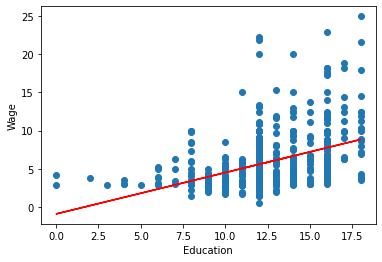

In [25]:
wage_hat = res.fittedvalues
plt.scatter('educ', 'wage', data=df)
plt.plot(df['educ'],wage_hat, 'r')
plt.xlabel('Education')
plt.ylabel('Wage')
pass

## モデルの適合度

モデルの適合度を確認するために次を定義する。

* SST（Total Sum of Squares; 全変動の平方和）

$$\text{SST}=\sum_{i=1}^n\left(y_i-\bar{y}\right)^2=(n-1)\cdot\text{Var}(y)$$

* SSE（Explained Sum of Squares; 回帰変動の平方和）

$$
\text{SSE}=\sum_{i=1}^n\left(\hat{y}_i-\bar{y}\right)^2=(n-1)\cdot\text{Var}\left(\hat{y}\right)
$$

* SSR（Residual Sum of Squares; 残差変動の平方和）

$$
\text{SSR}=\sum_{i=1}^n\left(\hat{u}_i-0\right)^2=(n-1)\cdot\text{Var}\left(\hat{u}\right)
$$

ここで，$\text{Var}(z)=\dfrac{1}{n-1}\sum_{i=1}^n\left(z_i-\bar{z}\right)^2$。これらを使い決定係数と自由度修正後の決定係数を定義する。

---
* 決定係数

$$R^2=\frac{SSE}{SST}=1-\frac{SSR}{SST}$$

$$
R^2
=\frac{\text{Var}\left(\hat{y}\right)}{\text{Var}\left(y\right)}
=1-\frac{\text{Var}\left(\hat{u}\right)}{\text{Var}\left(y\right)}
$$

* 自由度修正後の決定係数

$$\overline{R}^2=1-(1-R^2)\frac{n-1}{n-k-1}$$

ここで，$k=$ **定数項以外の説明変数の数**　（上の例では$k=1$）

ここで説明した変数の値は，上の例の`res`の属性として取得できる。
```
n = res.nobs
k = res.df_model
n-k-1 = res.df_resid
SST = res.centered_tss
SSE = res.ess
SSR = res.ssr
決定係数 = res.rsquared
修正済み決定係数 = res.rsquared_adj
```

In [26]:
n = res.nobs
k = res.df_model
# n-k-1 = res.df_resid
SST = res.centered_tss
SSE = res.ess
SSR = res.ssr

**決定係数**

上の定義を使うと次のように計算できる。

In [27]:
1-SSR/SST

0.16475751099205127

また次のように計算することも可能である。

In [28]:
u_hat = res.resid  # 残差
wage = df['wage']  # 被説明変数
R2 = 1 - np.var(u_hat) / np.var(wage)
R2

0.16475751099205116

しかし「手計算」よりも`res`の属性`.rsquared`を使う方がより簡単である。

In [29]:
res.rsquared

0.16475751099205127

**修正済み決定係数**

上の定義を使うと次のように計算できる。

In [30]:
adjR2 = 1-(1-R2)*(n-1)/(n-k-1)
adjR2

0.16316353677638717

一方で修正済み決定係数を取得するメソッドは`.rsquared_adj`である。

In [31]:
res.rsquared_adj

0.16316353677638717

## 賃金の対数化

上の回帰分析では被説明変数`wage`をそのまま使ったが，労働経済学では賃金の対数をとり推定するのが一般的である。そのような式を賃金方程式と呼ぶ。その考えに沿って，ここでは`wage`の自然対数変換をおこない回帰分析をおこなう。まず対数化賃金お変数を作成する。

In [32]:
df['wage_log'] = np.log(df['wage'])

In [33]:
formula = 'wage_log ~ educ'

In [34]:
res = ols(formula, data=df).fit()

In [35]:
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.097      5.998      0.000       0.393       0.775
educ           0.0827      0.008     10.935      0.000       0.068       0.098


**＜結果の解釈＞**

`res`は次式の推定結果である。

$$\ln y = \beta_0+\beta_1x+u$$

この式を$x$について微分すると

$$\dfrac{d\ln y}{dx}=\dfrac{dy/y}{dx}=\dfrac{y\text{の%変化}}{dx}=\beta_1$$

となる。即ち，$\beta_1$は$x$（教育年数）が一単位増加した場合，$y$（賃金）が何％変化するかを示している。この値は教育の収益率である。OLS推定結果は教育年数が１年増えると賃金は約8.3%増加することを示している。

```{note}
上の例では`wage_log`の変数を作成し計算したが、変数変換のコードを回帰式に直接書く方法もある。次章で説明することにする。
```

結果を図示しよう。

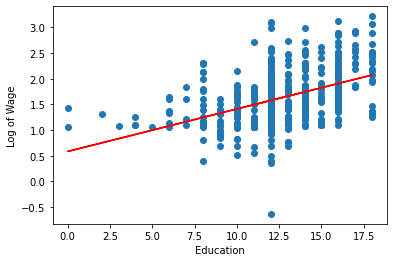

In [36]:
# 予測値の取得
wage_log_hat = res.fittedvalues

# 散布図と回帰曲線
plt.scatter('educ', 'wage_log', data=df)
plt.plot(df['educ'], wage_log_hat, 'r')
plt.xlabel('Education')
plt.ylabel('Log of Wage')
pass

## シミュレーション：$OLS$推定

上ではデータを使い「手計算」と`statsmodels`を使い係数を計算したが，ここではOLS推定の「意味」をシミュレーションを使って考えてみることにする。

### 母集団の考え方

母集団とは分析の対象となる共通の属性などを持つ個人・企業・産業・地域・国などの集合体といえる。ここで重要な点は母集団の大きさとランダム抽出の関係を理解することである。次の２つの例を使って考えてみよう。

* 「今年の人間の平均身長」を知りたいとしよう。この場合の母集団は地球上の全ての人間である。しかし，全員の身長を測るのはあまりにも費用が高いため，標本を集め，その平均から「人間の平均身長」を推定することが可能である（[参照](https://ja.wikipedia.org/wiki/大数の法則)）。この場合「標本の大きさ$<$母集団の大きさ」となる。
* 「今年のOECD諸国のGDP」についての何らかの統計量を計算したいとしよう。2021年現在でOECDには38カ国のメンバー国があり，GDPのデータは簡単に入手可能である。これは「標本の大きさ$=$母集団の大きさ」という意味なのだろうか。そうだとすれば，標本ではなく母集団全てのデータを扱うことになり，標本の概念である標準誤差などは意味がなくなることになる。しかし「標本の大きさ$<$母集団」と解釈できる２つの考え方がある。
    1. 時間は「無限」と考えることができる。この考えに従うと、38カ国のGDPデータも「無限」に存在することになる（OECDが存在する限りという意味での「無限」）。従って、ある時点の38カ国のGDPのデータは「無限」の母集団から抽出されたランダム変数と考えることができる。国と時間の概念で考えると母集団の大きさは非常に大きいと解釈できる。
    2. 確率変数とは実現可能な数値から１つを実現させる関数である。またGDP自体は確率変数として解釈する方が自然である（[「重回帰分析」](sec:9-assumptions))で説明する仮定２を参照）。従って，38カ国の**実現可能なGDPの値が母集団**となる。今年度のみでの実現可能なGDPは無数にあるため，この解釈によると「標本の大きさ$<$母集団の大きさ」となる。

### プラン

**＜Step 1＞**
* 母集団の大きさは指定しない。
* 母集団のデータを生成する回帰式（母集団回帰式）を定義する。

    $$Y = \beta_0 + \beta_1 X + U$$

    * 説明変数$X$と誤差項$U$はランダム変数であり，従って$Y$もランダム変数である。
* 母集団から標本を1組抽出し，標本の大きさを$n$とする。
    * 抽出された値はランダム変数の実現値である。
    
        $$(y_1,x_1),\;(y_2,x_2),.....(y_n,x_n)$$
        
    * 仮定
        * $X$は正規分布に従う $\Rightarrow$ $x_1,\;x_2,..x_n$は$X$の実現値。
        * $U$は正規分布に従う $\Rightarrow$ $u_1,\;u_2,..u_n$は$U$の実現値。
        * $X$と$U$は無相関。
        * 実現値$y_1,\;y_2,..y_n$は母集団回帰式に従って生成される。
        
            $$y_i = \beta_0 + \beta_1 x_i + u_i,\qquad i=1,2,3,....n$$
            
    * $\beta_0$と$\beta_1$は未知であり，$u_i$も観測不可能

**＜Step 2＞**
* Step 1で抽出した標本を使い回帰分析を行い，母集団の回帰式のパラメータを推定する。
    * $\hat{\beta}_0$，$\hat{\beta}_1$

### シミュレーション

母集団のパラメータを設定する。これはパラメータの真の値であり、この値を推定するのが回帰分析となる。

In [37]:
b0 = 1.0  # 定数項
b1 = 1.0  # 説明変数の係数
su = 1.0  # 誤差項の標準偏差

標本の大きさ

In [38]:
n = 30

標本を抽出するが、次の無作為なプロセスを通して生成されるとする。

In [39]:
x = norm.rvs(4, 1, size=n)
u = norm.rvs(0, su, size=n)
y = b0 + b1 * x + u

このデータから`DataFrame`を作成する。`()`の中の`{}`は辞書である。

In [40]:
df_sim = pd.DataFrame({'X':x, 'Y':y})

`statsmodels`を使って`OLS`推定する。

In [41]:
formula = 'Y ~ X'
res_sim = ols(formula, data=df_sim).fit()

係数の推定値を表示する。

In [42]:
res_sim.params

Intercept   -0.628719
X            1.392607
dtype: float64

母集団パラメータと比べると，推定誤差が発生していることがわかる。

```{note}
ランダム変数を発生させ回帰分析を行っていることに注意しよう。ここで生成したランダム変数は、読者が生成したランダム変数とは異なる。従って，係数の推定値も異なることになる。
```

### 関数化

次に，上で行ったシミュレーションのコードを関数にまとめることにする。

`def`を使い`my_sim`という名前の関数を作成する。
* 引数
    * 標本の大きさ：`n`
    * 真の定数項：`b0`（デフォルトは`1`）
    * 真のスロープ係数：`b1`（デフォルトは`1`）
    * 誤差項の標準偏差：`su`（デフォルトは`1`）
* 戻り値
    * 定数項とスロープ係数の推定値（`pandas.Series`）

In [43]:
def my_sim(n,b0=1,b1=1,su=1):  # nを指定する，　他はデフォルトを設定
    
    x = norm.rvs(4, 1, size=n)
    u = norm.rvs(0, su, size=n)
    y = b0 + b1 * x + u
    
    df_sim = pd.DataFrame({'X':x, 'Y':y})
    
    formula = 'Y ~ X'
    res_sim = ols(formula, data=df_sim).fit()
    
    return res_sim.params

`my_sim()`関数の中身は，上のコードと殆ど変わらないことに気付くはずである。

標本の大きさを指定して関数を実行してみよう。

In [44]:
my_sim(100)

Intercept    0.495868
X            1.177899
dtype: float64

`b0`，`b1`，`su`変えて計算してみよう。

---
シミュレーションで同じ計算を数十万回おこなう場合，１回のシミュレーションに時間がかかり，それをどのように高速化するかが問題になる。その際に役に立つパッケージが`Numba`であり，１行のコードを追加するだけで計算を驚く程高速化できる。しかし`Numba`には「相性」の問題がある。例えば，上の関数`my_sim()`で使った`statsmodels`，`pandas`，`scipy.stats`は`Numba`と相性が悪いが，`NumPy`は非常に相性が良い。また，`Numba`を使う際，リストよりも`array`を使う方が少しでも高速化を図ることができることも覚えておくと良いだろう。以下では，`Numba`を使う準備として，`NumPy`を使う「手計算」関数を考えることにする。

In [45]:
def my_sim_manual(n,b0=1,b1=1,su=1):  # nは標本の大きさ，　他はデフォルトを設定
    
    x = np.random.normal(loc=4, scale=1, size=n)   # 以下を参照
    u = np.random.normal(loc=0, scale=su, size=n)  # 以下を参照
    y = b0 + b1 * x + u
    
    var_cov = np.cov(y,x)   # 分散共分散行列
    cov_yx = var_cov[0,1]   # 共分散
    var_y = var_cov[0,0]    # yの分散
    var_x = var_cov[1,1]    # xの分散        
    avr_y = y.mean()        # yの平均
    avr_x = x.mean()        # xの平均
    
    b1hat = cov_yx / var_x  # スロープ係数の推定値
    b0hat = avr_y - b1hat*avr_x  # 定数項の推定値
    
    return b0hat, b1hat     # 推定値

ここで使った`np.random.normal()`について簡単に説明する。`NumPy`にはランダム変数を生成する`random`というサブパッケージがあり，その中の`normal()`を使う。これは`scipy.stats`の`norm.rvs()`と同じ引数を取り，同じ役割を果たす。

In [46]:
my_sim_manual(100)

(0.7927515259489519, 1.0936709752246927)

`my_sim()`と`my_sim_manual()`の推定値が異なるのはランダム変数（`y`，`x`）の値が異なるためであり，それが推定誤差による影響である。

### ループを使ってシミュレーション

標本による推定は誤差が発生する。その誤差はどれだけ大きく（小さく）何に依存するかを確認するために`for`ループを使い次のシミュレーションを行うことにする。

* 標本の大きさ`n`のデータを`N`組用意し（`N`は標本数），`OLS`推定を`N`回おこなう。
* シミュレーション毎に計算した回帰係数の推定値の分布を図示する。

まず`def`を使いシミュレーションの関数を作成するが，パラメータの推定値の計算には`statsmodels`を使わずに，`numpy`の関数を使い「手計算」とする。これにより計算を高速化するパッケージ`Numba`を使うことが可能となる。使い方は簡単でデコレーターと呼ばれる`@njit`（又は`@jit`）を関数の上に加えるだけである。これだけで計算速度が数十倍早くなる場合もある。そのために、まず上で使った`my_sim_manual`に`@njit`を加えて実行する。

In [47]:
@njit
def my_sim_manual(n,b0,b1,su):
    
    x = np.random.normal(loc=4, scale=1, size=n)
    u = np.random.normal(loc=0, scale=su, size=n)
    y = b0 + b1 * x + u
    
    var_cov = np.cov(y,x)
    cov_yx = var_cov[0,1]
    var_y = var_cov[0,0]
    var_x = var_cov[1,1]
    avr_y = y.mean()
    avr_x = x.mean()
    
    b1hat = cov_yx / var_x
    b0hat = avr_y - b1hat*avr_x
    
    return b0hat, b1hat

この`my_sim_manual()`の内容は，上で作成した`my_sim_manual()`と全く同じである。単に`@njit`の一行だけが付け加えられているだけだが，これにより全く別の高速化された関数に「変身」することになる。

次に`my_sim_manual()`を`for`ループで計算するシミュレーション用の関数を用意する。

In [48]:
@njit
def my_sim_loop(n,N,b0=1.0,b1=1.0,su=1.0):  # nとN以外はデフォルトを指定
    
    b0hat_arr = np.zeros(N)  # OLS推定量を入れるarray（0がN個並んでいる）
    b1hat_arr = np.zeros(N)  # OLS推定量を入れるarray（0がN個並んでいる）

    for i in range(N):  # N 回のループ
        
        # 返り値が２つあるので、割り当てる場合には左辺の変数を ',' で区切る 
        b0hat, b1hat = my_sim_manual(n,b0=b0,b1=b1,su=su)

        b0hat_arr[i] = b0hat  # i番目に定数項の推定値をarrに追加
        b1hat_arr[i] = b1hat  # i番目にスロープ係数の推定値をarrに追加
        
    return b0hat_arr, b1hat_arr  # N回ループ終了後にarrayをタプルとして返すオブジェクト

標本の大きさを`50`，シミュレーションの回数を`100_000`としてシミュレーションを始める。

In [49]:
b0hat, b1hat = my_sim_loop(n=50,N=100_000)

```{note}
初めて`my_sim_loop()`を実行すると`Numba`はコンパイルと呼ばれる高速化準備プロセスを経るため，`@njit`がない場合と比べて実行スピードは早くない。２回目の実行から`Numba`の効果がフルに発揮されることになる。
```

````{hint}
`Python`の`for`ループはコンパイル言語（例えば，`C`）と比べると実行速度が遅い。それを少しでも克服しようというのが`Numba`である。一方，`for`ループ自体を使わずに`Numpy`の特徴であるベクトル演算を使うと格段に実行速度が速くなる。例えば，`my_sim_loop`の代わりに次の関数を試してみよう。
```
def my_sim_vectorize(n,N,b0=1.0,b1=1.0,su=1.0):
    
    # 一度に全てのランダム変数を生成し，(n,N)のarrayに変換する
    x = np.random.normal(loc=4, scale=1, size=(n,N))
    u = np.random.normal(loc=0, scale=su, size=(n,N))
    y = b0 + b1*x + u

    # 平均の計算
    x_mean = x.mean(axis=0)
    y_mean = y.mean(axis=0)

    # 分散の計算
    x_var = x.var(axis=0)
    y_var = y.var(axis=0)

    # 平均からの乖離を計算
    x_mean_dev = x - x_mean
    y_mean_dev = y - y_mean

    # 共分散の計算
    yx_dev = y_mean_dev * x_mean_dev
    yx_cov = yx_dev.mean(axis=0)
    
    # 推定値の計算
    b1 = yx_cov / x_var
    b0 = y_mean - b1*x_mean
    
    return b0, b1
```
この関数には`for`ループはなく，戻り値`b0`と`b1`は`N`個の要素からなる推定値のarrayとなる。実行速度を比べるために次の２つのコードを別々のコードセルで実行してみよう。
```
%timeit my_sim_loop(n=50,N=1_000_000)
```
```
%timeit my_sim_vectorize(n=50,N=1_000_000)
```
ここで`%timeit`は実行速度を測るマジック・コマンドと呼ばれるコードである。`my_sim_vectorize`が２倍近く速くなることが確認できるだろう。`Numba`のようなパッケージを導入しなくても，ベクトル演算を使う方が計算の時間を短縮できることを覚えておこう。
````

$\hat{\beta}_0$の分布を図示する。

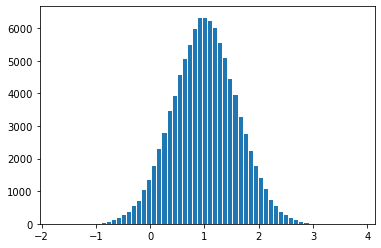

In [50]:
plt.hist(b0hat,bins=60, edgecolor='white')
pass

$\hat{\beta}_1$の分布を図示する。

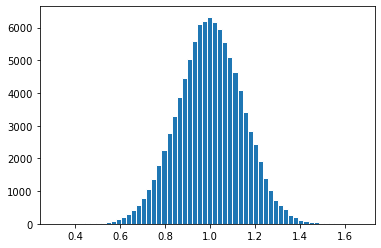

In [51]:
plt.hist(b1hat,bins=60, edgecolor='white')
pass

`y`の理論値を図示するが，図示の時間短縮のために`N`回のシミュレーション中の最初の`r`回の回帰線だけを表示する。

In [52]:
r = 1000

`r`回の回帰線を`for`ループを使って重ねて図示してみよう。

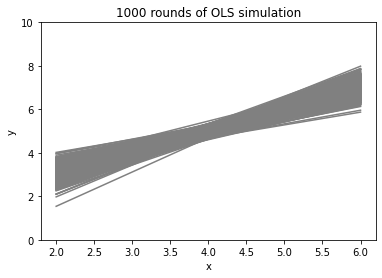

In [53]:
xx = np.linspace(2,6,50)

for i in range(r):  # r回のループで図示
    yhat = b0hat[i] + b1hat[i]*xx  # yの予測値
    plt.plot(xx, yhat, 'grey')  # yの予測値を図示
    
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0,10) # 縦軸の表示範囲を設定
plt.title(f'{r} rounds of OLS simulation')
pass

```{admonition} コードの説明
上のコード・ブロックの最後から２行目に`f'{r} rounds of OLS simulation'`とある。文字列の前に`f`を置き、文字列の中で上で定義した変数を`{}`で囲むとその変数の値を代入することができる。これを`f-string`と呼ぶ。
```

---
**＜シミュレーションの含意＞**

まず上の２つのヒストグラムをみると，値にばらつきがある。これは推定量（$\hat{\beta}_0$と$\hat{\beta}_1$）が確率変数であるためである。その実現値は，真の値（$\beta_0=1.0$と$\beta_1=1.0$）を中心に左右対象に分布している。即ち，推定量は不偏性を満たしている。次の章で簡単に説明するが，上で行ったシミュレーションは不偏推定量に必要な仮定を満たしているためである。

これを踏まえて，回帰直線の図を考えよう。同じ回帰式を使い`N`回のシミュレーションを行った後，最初の`r`個の回帰直線を重ねて描いているためパイプのような形になっている。一方で，実際の実証分析ではこのような繰り返しの試行は不可能であり多くの場合は一度だけである。言い換えると，実証研究では`N`個の回帰直線の中から１つだけを結果として「ランダムに選んでいる」のと等しい。この意味を更に考えるために，（標本の大きさは所与として）たまたま２組みのデータセットが手に入り，別々の回帰分析を行ったとしよう。その場合，パイプの幅が広ければ広いほど，２つの回帰直線の位置は大きく異なる可能性が高くなり，正確性が低い結果になる。逆に，パイプの幅が狭ければ狭いほど，２つの結果は似たものになり，より正確な推定結果となる。このように実証分析ではパイプの幅が可能な限り小さくなる工夫が必要になる。その１つが標本の大きさ`n`である。`n`が増えるとパイプは細くなり，極限$n\rightarrow\infty$（即ち，標本の大きさと母集団の大きさの差が限りなくゼロに近づく）ではパイプの形が直線（母集団回帰式）に近づくことになる。このように，実証分析において標本の大きさは非常に重要な役割を果たすことになる。

```{warning}
* このシミュレーションの場合，推定量の**一致性**が満たされているため，パイプが母集団回帰式に収束することになる。しかし一般的に必ずそうなるとは限らない。ある仮定のもとでのみ推定量は一致性を満たすことになる。
* 推定方法によっては，不偏性は満たさないが一致性を満たす推定量も存在する。また，エギゾチックな例になるがその逆もあり得る。
```

----- Give it a try! -----

標本の大きさ`n`を変えて試してみよう。例えば，10, 30, 100, 500, 1000。